# Notebook Approche Supervisée - Baseline

In [1]:
from sklearn.ensemble import RandomForestClassifier
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import mlflow.sklearn
import pandas as pd
import seaborn as sns
import mlflow
import re
import time

def create_confusion_matrix(conf_matrix, path):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix - Combined Pipeline')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.savefig(path)
    plt.show()

def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, model_params):
    with mlflow.start_run():
        # Paramètres du modèle
        for key, value in model_params.items():
            mlflow.log_param(key, value)

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        mlflow.log_metric("accuracy", accuracy)
        mlflow.sklearn.log_model(model, "model")

def train_and_evaluate(X, y):
    mlflow.start_run()
    param_max_depth = 10
    param_n_estimators = 100

    # enregistrez les paramètres
    mlflow.log_param("max_depth", param_max_depth)
    mlflow.log_param("n_estimators", param_n_estimators)

    model = RandomForestClassifier(max_depth=param_max_depth, n_estimators=param_n_estimators)
    model.fit(X, y)
    y_pred = model.predict(X)

    accuracy = accuracy_score(y, y_pred)
    mlflow.log_metric("accuracy", accuracy)
    mlflow.sklearn.log_model(model, "model")
    mlflow.end_run()

def evaluate_and_log_metrics(experiment_name, model_name, model_type, y_test, y_predicted, training_time = None):

    experiment = mlflow.get_experiment_by_name(experiment_name)
    if experiment is None:
        mlflow.create_experiment(experiment_name)
        experiment = mlflow.get_experiment_by_name(experiment_name)

    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted, average='weighted')
    recall = recall_score(y_test, y_predicted, average='weighted')
    f1 = f1_score(y_test, y_predicted, average='weighted')

    with mlflow.start_run(experiment_id=experiment.experiment_id):
        mlflow.log_param("model_type", model_type)
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)
        if (training_time != None):
            mlflow.log_metric("training_time", training_time)

        # enregistrer le modèle dans le registre MLFlow
        model_uri = f"runs:/{mlflow.active_run().info.run_id}/model"
        mlflow.register_model(model_uri, model_name)
        
        # Passer le modèle en staging
        switch_model_to_staging(mlflow, model_name)
    return accuracy, precision, recall, f1

def switch_model_to_staging(mlflow, model_name):
    client = mlflow.tracking.MlflowClient()
    model_version_details = client.get_latest_versions(model_name, stages=["None"])[0]
    
    client.transition_model_version_stage(
        name=model_name,
        version=model_version_details.version,
        stage="Staging"
    )

def plot_monthly_metrics(accuracies, precisions, recalls, f1_scores, months, file_path):
    plt.figure(figsize=(12, 6))
    plt.plot(months, accuracies, label='Accuracy', marker='o')
    plt.plot(months, precisions, label='Precision', marker='s')
    plt.plot(months, recalls, label='Recall', marker='^')
    plt.plot(months, f1_scores, label='F1 Score', marker='d')

    plt.xlabel('Months')
    plt.ylabel('Metrics')
    plt.title('Monthly Performance Metrics')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(file_path)
    plt.show()
    plt.close()

def preprocess_text(text):
    text = lowercase_text(text)
    text = remove_urls(text)
    # Tokenization
    word_tokens = tokenization(text)
    word_tokens = clear_ponctuation(word_tokens)
    # custom clean
    word_tokens = custom_clean(word_tokens)
    # Lemmatisation
    lemmatized_words = lemmatization(word_tokens)
    # suppression des stopwords
    return remove_stopwords(lemmatized_words)

def remove_urls(text):
    regex = r'https?://\S+|www\.\S+'
    text = re.sub(regex, '', text)
    return text

def custom_clean(text):
    # remplacer les sauts de lignes par des espaces
    word_tokens = [word_token.replace('\n', ' ') for word_token in text]
    # supprimer les espaces en trop
    word_tokens = [re.sub(r'\s+', ' ', phrase) for phrase in word_tokens]
    return word_tokens

def lowercase_text(text):
    return text.lower()

def tokenization(text):
    return sent_tokenize(text)

def lemmatization(word_tokens):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in word_tokens]

def lemmatize_and_flatten(phrases):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for phrase in phrases for word in ' '.join(phrase).split()]

def remove_stopwords(sentences):
    stop_words = set(stopwords.words('english'))
    result = []
    for sentence in sentences:
        words = sentence.split()
        filtered_words = [word for word in words if word.lower() not in stop_words]
        result.append(' '.join(filtered_words))
    return result

def clear_ponctuation(text):
    return [re.sub(r'[^a-zA-Z0-9\s]', '', phrase) for phrase in text]

def extract_text_from_body(html_body):
    soup = BeautifulSoup(html_body, 'html.parser')
    return soup.get_text()

def transform_tags(tags_string):
    tags = re.findall(r'<(.*?)>', tags_string)
    cleaned_tags = ','.join(tags)
    return cleaned_tags


In [2]:
from sklearn.model_selection import train_test_split

data = pd.read_csv("dataset_cleaned.csv")

data['creationdate'] = pd.to_datetime(data['creationdate'])

train_data, test_data = train_test_split(data, test_size=0.3)

print(len(test_data))
print(len(train_data))

train_data_filtered = train_data[train_data['creationdate'] < pd.Timestamp('2023-01-01')]

test_data_filtered = test_data[test_data['creationdate'] < pd.Timestamp('2023-01-01')]

X_train = train_data_filtered[['title_lemmatized', 'body_lemmatized', 'creationdate']]
y_train_original = train_data_filtered['tags_transformed']

X_test = test_data_filtered[['title_lemmatized', 'body_lemmatized', 'creationdate']]
y_test_original = test_data_filtered['tags_transformed']

13609
31753


## MultiLabelBinarizer (Pour Entrainer le modèle sur les 100 tags les plus fréquents)

In [3]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from collections import Counter

y_train_lists = [tags_str.split(',') for tags_str in y_train_original]
y_test_lists = [tags_str.split(',') for tags_str in y_test_original]
tag_counts = Counter(tag for tags_list in y_train_lists for tag in tags_list)

# Garder les 100 tags les plus fréquents
N = 100
top_tags = [tag for tag, _ in tag_counts.most_common(N)]

# Convertir les listes de tags en représentation binaire
mlb = MultiLabelBinarizer(classes=top_tags)
y_train = mlb.fit_transform(y_train_lists)
y_test = mlb.transform(y_test_lists)

print(y_train.shape)
print(y_test.shape)

(31715, 100)
(13595, 100)


/Users/flo/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['.app', '.class-file', '.doc', '.hgtags', '.htaccess', '.htpasswd', '.lib', '.net-2.0', '.net-3.0', '.net-3.5', '.net-4.0', '.net-4.5', '.net-4.6', '.net-4.8', '.net-5', '.net-6.0', '.net-7.0', '.net-assembly', '.net-attributes', '.net-core', '.net-core-2.0', '.net-core-2.1', '.net-core-2.2', '.net-core-3.0', '.net-core-3.1', '.net-core-logging', '.net-core-rc1', '.net-core-rc2', '.net-framework-version', '.net-mac', '.net-standard', '.net-standard-1.5', '.net-standard-2.0', '.net-standard-2.1', '.netrc', '.profile', '.so', '128-bit', '16-bit', '2-way-object-databinding', '2d', '3-tier', '32-bit', '32bit-64bit', '3d', '3d-model', '3d-modelling', '3d-reconstruction', '3g', '4g', '64-bit', '7zip', 'a-star', 'a2dp', 'aac', 'aadhaar', 'aapt', 'aar', 'abaddressbook', 'abbreviation', 'abc', 'abcl', 'abi', 'abort', 'abrecord', 'absl-py', 'absolute', 'absolute-path', 'absolute

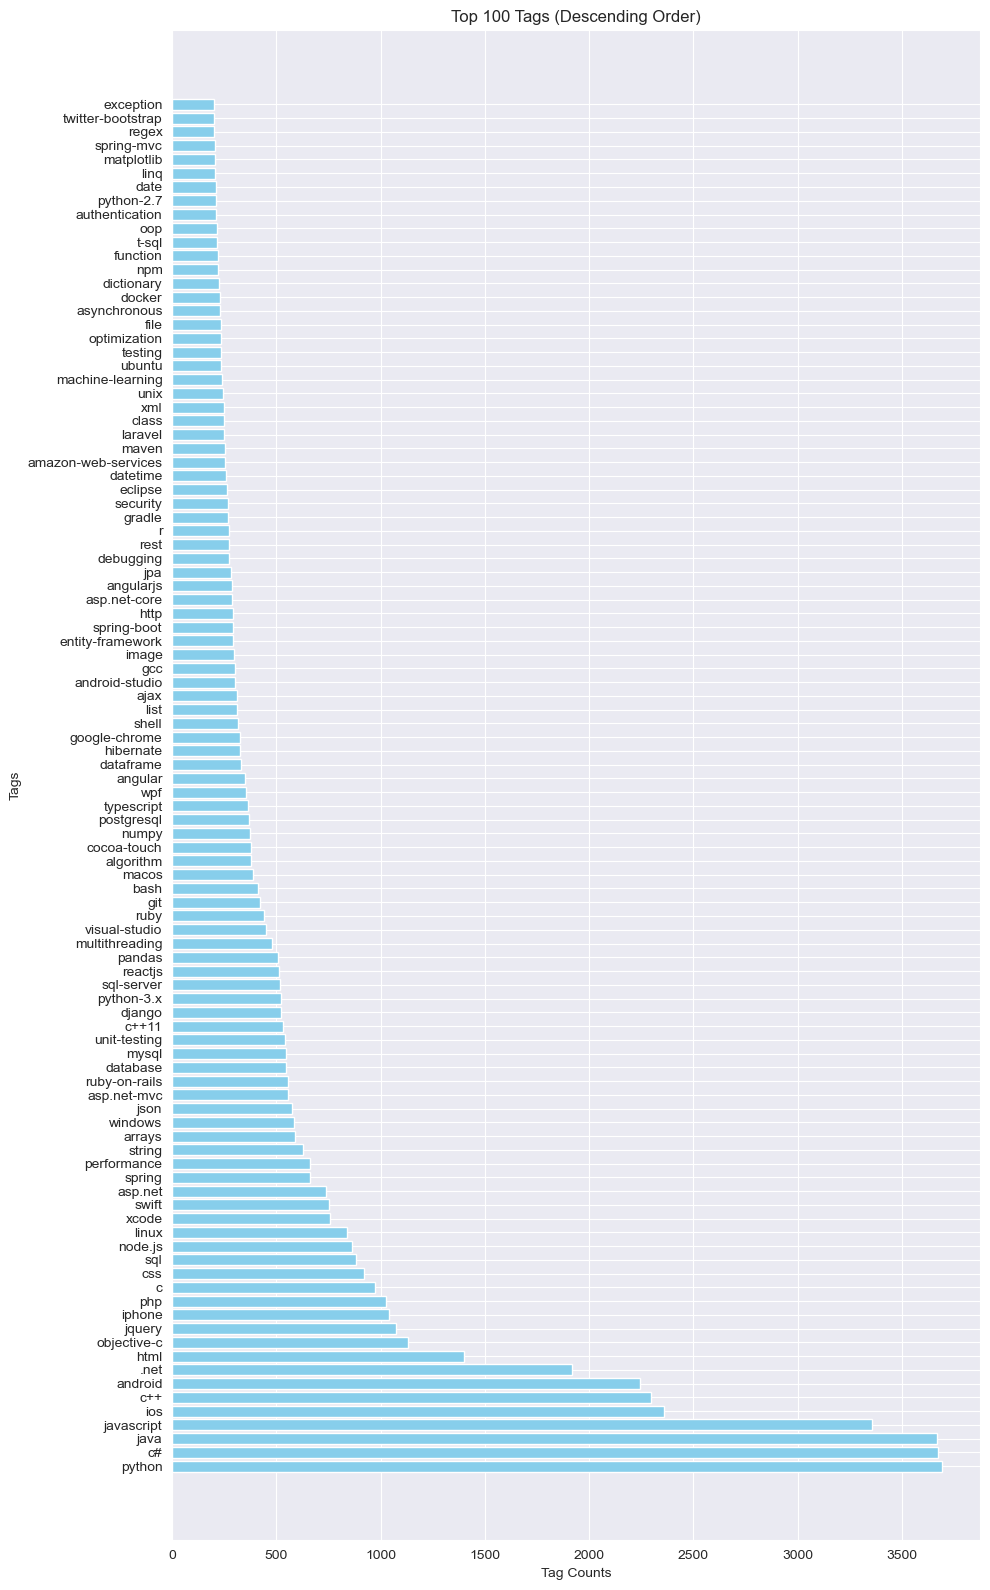

In [4]:
import matplotlib.pyplot as plt
from collections import Counter

top_tag_counts = Counter(tag for tags_list in y_train_lists for tag in tags_list if tag in top_tags)
top_tag_names, top_tag_counts = zip(*top_tag_counts.items())

sorted_indices = sorted(range(len(top_tag_counts)), key=lambda k: top_tag_counts[k], reverse=True)
top_tag_names = [top_tag_names[i] for i in sorted_indices]
top_tag_counts = [top_tag_counts[i] for i in sorted_indices]

plt.figure(figsize=(10, 16))
plt.barh(top_tag_names, top_tag_counts, color='skyblue')
plt.xlabel('Tag Counts')
plt.ylabel('Tags')
plt.title('Top {} Tags (Descending Order)'.format(N))
plt.tight_layout()

plt.show()


## CountVectorizer

### Train OneVsRestClassifier

In [5]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer

title_classifier = MultinomialNB()
body_classifier = MultinomialNB()
combined_classifier = MultinomialNB()

titleOneRestclassifier = OneVsRestClassifier(title_classifier)
bodyOneRestclassifier = OneVsRestClassifier(body_classifier)
combinedOneRestclassifier = OneVsRestClassifier(combined_classifier)

combined_pipeline = Pipeline([
    ('vectorizer_combined', CountVectorizer()),
    ('classifier', combinedOneRestclassifier)
])

X_train_combined = X_train['title_lemmatized'] + ' ' + X_train['body_lemmatized']
X_test_combined = X_test['title_lemmatized'] + ' ' + X_test['body_lemmatized']

combined_pipeline.fit(X_train_combined, y_train)

Pipeline(steps=[('vectorizer_combined', CountVectorizer()),
                ('classifier', OneVsRestClassifier(estimator=MultinomialNB()))])

### Predict OneVsRestClassifier

In [6]:
import numpy as np

X_combined_test_transformed = combined_pipeline.named_steps['vectorizer_combined'].transform(X_test_combined)

predictions_proba_combined = combined_pipeline.predict_proba(X_test_combined)

n_top_classes = 5

top_classes_indices_combined = np.argsort(predictions_proba_combined)[:, -n_top_classes:]

top_tags_combined = mlb.classes_[top_classes_indices_combined]


## Sauvegarde du modèle

In [7]:
from joblib import dump
import shutil

pipeline_file = 'oneVsRestClassifier_mlb_model.joblib'
mlb_file = 'mlb_model.joblib'

dump(combined_pipeline, pipeline_file)
dump(mlb, mlb_file)

destination_folder = '../api/app/models_src'

shutil.copy(pipeline_file, destination_folder)
shutil.copy(mlb_file, destination_folder)

'../api/app/models_src/mlb_model.joblib'

## Récupérer les tags les plus proches (en utilisant predict_proba)

In [8]:
# Liste des questions à prédire (title + body)
questions_to_predict = ["How can you implement a thread-safe singleton in Java?", "#*Whatnot** is a livestream shopping platform and marketplace backed by Andreessen Horowitz, Y Combinator, and CapitalG. We’re building the future of ecommerce, bringing together community, shopping and entertainment. We are committed to our values, whether working remotely or from one of our offices. We are building a team that has experience from top tech, retail and payments platforms in the world. We’re innovating in the fast-paced world of live auctions in categories including sports, fashion, video games, and streetwear. The platform couples rigorous seller vetting with a focus on community to create a welcoming space for buyers and sellers to share their passions with others. And, we’re growing. Whatnot has been the fastest growing marketplace in the US over the past two years and we’re hiring forward-thinking problem solvers across all functional areas. Retail disruption is one of the largest opportunities in the startup space today. Livestream shopping is taking off around the world – a $300B GMV market in China that’s grown 100% YoY. Whatnot is bringing it to the world through a community-first approach, starting in the U.S. where retail is a $5T market opportunity! We are looking for intellectually curious, highly motivated individuals to join us for a 12-week remote internship during summer 2024. Our interns work in cross-functional multidisciplinary teams enabling you to directly impact the direction of our platform. Your code and ideas will contribute to solving some of the most complex technical challenges we face today and define future engineering initiatives.    - Building new features for users in our live-streams - Implementing growth tactics and strategies to scale our buyer and seller flows - Building systems at scale that help us deliver a high trust marketplace experience By the end of your internship, you will have contributed to one of the fastest growing marketplaces ever while gaining core industry skills of project ideation, management and collaboration Curious about who thrives at Whatnot? We’ve found that low ego, a growth mindset, and leaning into action and high impact goes a long way here. As our next Engineering Intern you should have some industry software engineering experience, plus: - Pursuing a degree in computer science or other related major graduating in 2025 - Problem solver and out-of-the-box thinker - Willing to take risks and build product and systems for 1M+ users    - Ability to pick up on new technologies quickly"]

predictions_proba_combined_multiple = combined_pipeline.predict_proba(questions_to_predict)
n_top_classes = 5

for i, question in enumerate(questions_to_predict):
    top_classes_indices = predictions_proba_combined_multiple.argsort(axis=1)[:, -n_top_classes:][i]
    top_classes_probabilities = predictions_proba_combined_multiple[i, top_classes_indices]

    # Tri des classes et des probabilités par ordre décroissant de probabilité
    sorted_indices = np.argsort(top_classes_probabilities)[::-1]
    top_tags_combined_sorted = mlb.classes_[top_classes_indices[sorted_indices]]
    top_classes_probabilities_sorted = top_classes_probabilities[sorted_indices]

    print(f"Tags associés pour la question '{question}':", list(zip(top_tags_combined_sorted, top_classes_probabilities_sorted)))
    print("\n")


Tags associés pour la question 'How can you implement a thread-safe singleton in Java?': [('java', 0.8625540157419973), ('c#', 0.023497710924962625), ('multithreading', 0.016271358549494384), ('c++', 0.008637626609477953), ('android', 0.002764793750890456)]


Tags associés pour la question '#*Whatnot** is a livestream shopping platform and marketplace backed by Andreessen Horowitz, Y Combinator, and CapitalG. We’re building the future of ecommerce, bringing together community, shopping and entertainment. We are committed to our values, whether working remotely or from one of our offices. We are building a team that has experience from top tech, retail and payments platforms in the world. We’re innovating in the fast-paced world of live auctions in categories including sports, fashion, video games, and streetwear. The platform couples rigorous seller vetting with a focus on community to create a welcoming space for buyers and sellers to share their passions with others. And, we’re growi

## Évaluation du modèle de référence

In [9]:
top_tags_combined_predicted = mlb.transform(top_tags_combined)
experiment_name = 'MultinomialNB'
model_name = 'MultinomialNB'

accuracy_combined, precision_combined, recall_combined, f1_combined = evaluate_and_log_metrics(experiment_name, model_name, "combined", y_test, top_tags_combined_predicted)
print("\nCombined Pipeline Metrics (Top 5 classes):")
print("Accuracy:", accuracy_combined)
print("Precision:", precision_combined)
print("Recall:", recall_combined)
print("F1 Score:", f1_combined)


/Users/flo/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Combined Pipeline Metrics (Top 5 classes):
Accuracy: 0.0003677822728944465
Precision: 0.39541246576366057
Recall: 0.5835728952772073
F1 Score: 0.339164059475599


Registered model 'MultinomialNB' already exists. Creating a new version of this model...
Created version '23' of model 'MultinomialNB'.
/var/folders/cg/0gx_zldn535fk5xp_qrwk8wr0000gn/T/ipykernel_2046/3576892574.py:85: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.9.1/model-registry.html#migrating-from-stages
  model_version_details = client.get_latest_versions(model_name, stages=["None"])[0]
/var/folders/cg/0gx_zldn535fk5xp_qrwk8wr0000gn/T/ipykernel_2046/3576892574.py:87: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow

In [10]:
data = pd.read_csv("dataset_cleaned.csv")
data['creationdate'] = pd.to_datetime(data['creationdate'])
full_data = data['title_lemmatized'] + ' ' + data['body_lemmatized']


### Nouveau Algo (XLNet) 

In [11]:
import numpy as np
import torch
import time
from transformers import XLNetTokenizer, XLNetForSequenceClassification
from torch.nn import DataParallel
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', max_length=128)
model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels=100)

class XLNetPipeline:
    def __init__(self, model):
        self.model = model
        self.threshold = 0.3
        self.optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
        self.loss_fn = torch.nn.BCEWithLogitsLoss()

    def fit(self, X, y, epochs=6, batch_size=4):
        if torch.cuda.device_count() > 1:
            print("Utilisation de", torch.cuda.device_count(), "GPUs pour l'entraînement.")
            self.model = DataParallel(self.model)
        for epoch in range(epochs):
            epoch_loss = 0.0
            for i in range(0, len(X), batch_size):
                batch_texts = X[i:i+batch_size]
                batch_labels = torch.tensor(y[i:i+batch_size], dtype=torch.float32)

                inputs = tokenizer(batch_texts, padding=True, truncation=True, return_tensors='pt')
                labels = batch_labels

                self.optimizer.zero_grad()  # Reset le gradient
                outputs = self.model(**inputs)
                logits = outputs.logits

                loss = self.loss_fn(logits, labels)
                loss.backward()  # Backpropagation
                self.optimizer.step()

                epoch_loss += loss.item()

            print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss}")


    def predict(self, X):
        predictions = []
        class_counts = Counter(mlb.classes_)
        N = 100
        top_classes = [class_name for class_name, _ in class_counts.most_common(N)]
        with torch.no_grad():
            for text in X:
                inputs = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
                outputs = self.model(**inputs)
                logits = outputs.logits
                probabilities = torch.sigmoid(logits).detach().numpy()

                specific_class_indices = [mlb.classes_.tolist().index(cls) for cls in top_classes]
                specific_class_probabilities = probabilities[:, specific_class_indices]

                binary_predictions = (specific_class_probabilities >= self.threshold).astype(int)
                predictions.append(binary_predictions)
        return np.squeeze(predictions)

# Define and instantiate the pipeline
pipeline_xlnet = XLNetPipeline(model)

/Users/flo/anaconda3/lib/python3.11/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
X_train_xlnet, X_test_xlnet, y_train_xlnet, y_test_xlnet = train_test_split(X_train['title_lemmatized'], y_train, test_size=0.2, random_state=42)

X_test_xlnet_formatted = []
X_train_xlnet_formatted = []

for document in X_test_xlnet:
    concatenated_document = ''.join([phrase.strip("[]'") for phrase in document])
    X_test_xlnet_formatted.append(concatenated_document)

for document in X_train_xlnet:
    concatenated_document = ''.join([phrase.strip("[]'") for phrase in document])
    X_train_xlnet_formatted.append(concatenated_document)

start_time = time.time()

pipeline_xlnet.fit(X_train_xlnet_formatted[:25000], y_train_xlnet[:25000])

end_time = time.time()
training_time = end_time - start_time
print("Temps d'entrainement:", training_time, "secondes")


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Epoch 1/6, Loss: 577.4314075466245
Epoch 2/6, Loss: 463.74946377798915
Epoch 3/6, Loss: 393.03722534142435
Epoch 4/6, Loss: 342.7439228994772
Epoch 5/6, Loss: 304.4516125563532
Epoch 6/6, Loss: 269.66832454688847
Temps d'entrainement: 68485.18748807907 secondes


#### Sauvegarder le modèle XLNet

In [16]:
pipeline_file = 'XLNet_custom_classification_layer_model.joblib'
dump(pipeline_xlnet, pipeline_file)
destination_folder = '../api/app/models_src'
shutil.copy(pipeline_file, destination_folder)

'../api/app/models_src/XLNet_custom_classification_layer_model.joblib'

In [14]:
model_name = 'XLNet - Custom classification layer'
experiment_name = 'XLNet - Custom classification layer'

# Make predictions on the test data
predictions_xlnet = pipeline_xlnet.predict(X_test_xlnet_formatted[:1500])

top_classes_indices_combined = np.argsort(predictions_xlnet)[:, -n_top_classes:]
top_tags_combined = mlb.classes_[top_classes_indices_combined]
top_tags_combined_predicted = mlb.transform(top_tags_combined)

accuracy_combined, precision_combined, recall_combined, f1_combined = evaluate_and_log_metrics(experiment_name, model_name, "title", y_test_xlnet[:1500], top_tags_combined_predicted, training_time)

print("\nTitle XLNet Metrics (Top 5 classes):")
print("Accuracy:", accuracy_combined)
print("Precision:", precision_combined)
print("Recall:", recall_combined)
print("F1 Score:", f1_combined)


Title XLNet Metrics (Top 5 classes):
Accuracy: 0.0006666666666666666
Precision: 0.5179441851021718
Recall: 0.5355099293167284
F1 Score: 0.49385277721668913


/Users/flo/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Registered model 'XLNet - Custom classification layer' already exists. Creating a new version of this model...
Created version '15' of model 'XLNet - Custom classification layer'.
/var/folders/cg/0gx_zldn535fk5xp_qrwk8wr0000gn/T/ipykernel_2046/3576892574.py:85: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.9.1/model-registry.html#migrating-from-stages
  model_version_details = client.get_latest_versions(model_name, stages=["None"])[0]
/var/folders/

In [15]:
len(X_train_xlnet)

25372

In [22]:
import joblib

# Charger le fichier de modèle
pipeline_xlnet_joblib = joblib.load('XLNet_custom_classification_layer_model.joblib')

# Afficher le contenu du fichier de modèle
print(pipeline_xlnet_joblib)
